# Getting started with TinyTimeMixer (TTM)

This notebooke demonstrates the usage of a pre-trained `TinyTimeMixer` model for several multivariate time series forecasting tasks. For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

In this example, we will use a pre-trained TTM-512-96 model. That means the TTM model can take an input of 512 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Few-shot**: The pre-trained TTM will be quickly fine-tuned on only 5% of the `train` split of the target data, and subsequently, evaluated on the `test` part of the target data.

Note: Alternatively, this notebook can be modified to try the TTM-1024-96 model.

Pre-trained TTM models will be fetched from the [Hugging Face TTM Model Repository](https://huggingface.co/ibm-granite/granite-timeseries-ttm-v1).

## Installation

In [1]:
# Install the tsfm library
# ! pip install "tsfm_public[notebooks] @ git+ssh://git@github.com/ibm-granite/granite-tsfm.git"

## Imports

In [1]:
import math
import os
import tempfile

import pandas as pd
import numpy as np
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed

from tsfm_public import (
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
    TrackingCallback,
    count_parameters,
    get_datasets,
)
from tsfm_public.toolkit.visualization import plot_predictions

## Read datasets

In [2]:
data_dir = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'data/')

meta_path = os.path.join(data_dir, 'metadata/metadata.csv')
meter_dir = os.path.join(data_dir, 'meters/cleaned/')
weather_path = os.path.join(data_dir, 'weather/weather.csv')

for dirname, _, filenames in os.walk(meter_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/jiaqwu/Documents/Eureka/A_Projects/0000_Repository/building-data-genome-project-2/data/meters/cleaned/chilledwater_cleaned.csv
/Users/jiaqwu/Documents/Eureka/A_Projects/0000_Repository/building-data-genome-project-2/data/meters/cleaned/steam_cleaned.csv
/Users/jiaqwu/Documents/Eureka/A_Projects/0000_Repository/building-data-genome-project-2/data/meters/cleaned/hotwater_cleaned.csv
/Users/jiaqwu/Documents/Eureka/A_Projects/0000_Repository/building-data-genome-project-2/data/meters/cleaned/gas_cleaned.csv
/Users/jiaqwu/Documents/Eureka/A_Projects/0000_Repository/building-data-genome-project-2/data/meters/cleaned/irrigation_cleaned.csv
/Users/jiaqwu/Documents/Eureka/A_Projects/0000_Repository/building-data-genome-project-2/data/meters/cleaned/electricity_cleaned.csv
/Users/jiaqwu/Documents/Eureka/A_Projects/0000_Repository/building-data-genome-project-2/data/meters/cleaned/solar_cleaned.csv
/Users/jiaqwu/Documents/Eureka/A_Projects/0000_Repository/building-data-genome-project-2/dat

In [3]:
metadata = pd.read_csv(meta_path)
education = metadata[metadata['primaryspaceusage'] == 'Education']
edu_electricity = education[education['electricity'].notna()]
edu_electricity.info()

<class 'pandas.core.frame.DataFrame'>
Index: 604 entries, 3 to 1625
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   building_id            604 non-null    object 
 1   site_id                604 non-null    object 
 2   building_id_kaggle     542 non-null    float64
 3   site_id_kaggle         604 non-null    float64
 4   primaryspaceusage      604 non-null    object 
 5   sub_primaryspaceusage  604 non-null    object 
 6   sqm                    604 non-null    float64
 7   sqft                   604 non-null    float64
 8   lat                    561 non-null    float64
 9   lng                    561 non-null    float64
 10  timezone               604 non-null    object 
 11  electricity            604 non-null    object 
 12  hotwater               81 non-null     object 
 13  chilledwater           229 non-null    object 
 14  steam                  141 non-null    object 
 15  water     

In [4]:
weather = pd.read_csv(weather_path)
sites = edu_electricity['site_id'].unique()
sites

array(['Panther', 'Robin', 'Fox', 'Rat', 'Bear', 'Lamb', 'Peacock',
       'Moose', 'Bull', 'Bobcat', 'Crow', 'Wolf', 'Hog', 'Eagle',
       'Cockatoo'], dtype=object)

In [5]:
# site_weather = weather[weather['site_id'].isin(sites)]
site_weather = weather[weather['site_id'] == sites[2]]
site_air_temperature = site_weather[site_weather['airTemperature'].notna()]
site_air_temperature.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17542 entries, 35060 to 52602
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   timestamp       17542 non-null  object 
 1   site_id         17542 non-null  object 
 2   airTemperature  17542 non-null  float64
 3   cloudCoverage   12573 non-null  float64
 4   dewTemperature  17542 non-null  float64
 5   precipDepth1HR  17471 non-null  float64
 6   precipDepth6HR  160 non-null    float64
 7   seaLvlPressure  17490 non-null  float64
 8   windDirection   16328 non-null  float64
 9   windSpeed       17531 non-null  float64
dtypes: float64(8), object(2)
memory usage: 1.5+ MB


## Important arguments

In [6]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

target_dataset = "air_temperature"

# Results dir
OUT_DIR = "ttm_finetuned_models/"

# TTM model branch
# Use main for 512-96 model
# Use "1024_96_v1" for 1024-96 model
TTM_MODEL_REVISION = "main"

# Forecasting parameters
context_length = 512
forecast_length = 96
fewshot_fraction = 0.25

## Data processing pipeline

In [7]:
round(site_air_temperature.isna().sum()/len(site_air_temperature)*100, 2)

timestamp          0.00
site_id            0.00
airTemperature     0.00
cloudCoverage     28.33
dewTemperature     0.00
precipDepth1HR     0.40
precipDepth6HR    99.09
seaLvlPressure     0.30
windDirection      6.92
windSpeed          0.06
dtype: float64

In [8]:
# Load the data file and see the columns
columns_to_check = ['precipDepth1HR', 'seaLvlPressure', 'windSpeed']

# Drop rows with NaNs in the specified columns
site_air_temperature_cleaned = site_air_temperature.dropna(
    subset=columns_to_check)
site_air_temperature_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17415 entries, 35060 to 52602
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   timestamp       17415 non-null  object 
 1   site_id         17415 non-null  object 
 2   airTemperature  17415 non-null  float64
 3   cloudCoverage   12517 non-null  float64
 4   dewTemperature  17415 non-null  float64
 5   precipDepth1HR  17415 non-null  float64
 6   precipDepth6HR  160 non-null    float64
 7   seaLvlPressure  17415 non-null  float64
 8   windDirection   16221 non-null  float64
 9   windSpeed       17415 non-null  float64
dtypes: float64(8), object(2)
memory usage: 1.5+ MB


In [9]:
columns_to_extract = ['timestamp', 'airTemperature',
                      'dewTemperature', 'precipDepth1HR', 'seaLvlPressure', 'windSpeed']
df_tmp = site_air_temperature_cleaned[columns_to_extract]
df_tmp

,timestamp,airTemperature,dewTemperature,precipDepth1HR,seaLvlPressure,windSpeed
35060,2016-01-01 00:00:00,7.2,-5.6,0.0,1017.3,0.0
35061,2016-01-01 01:00:00,7.2,-6.7,0.0,1017.0,1.5
35062,2016-01-01 02:00:00,6.1,-5.0,0.0,1016.9,0.0
35063,2016-01-01 03:00:00,5.0,-5.6,0.0,1017.4,0.0
35064,2016-01-01 04:00:00,4.4,-5.6,0.0,1017.2,0.0
...,...,...,...,...,...,...
52598,2017-12-31 19:00:00,16.1,-2.8,0.0,1017.3,1.5
52599,2017-12-31 20:00:00,13.3,-2.2,0.0,1017.6,1.5
52600,2017-12-31 21:00:00,13.3,-2.8,0.0,1017.9,0.0
52601,2017-12-31 22:00:00,12.2,-1.1,0.0,1018.3,1.5


<Axes: xlabel='timestamp'>

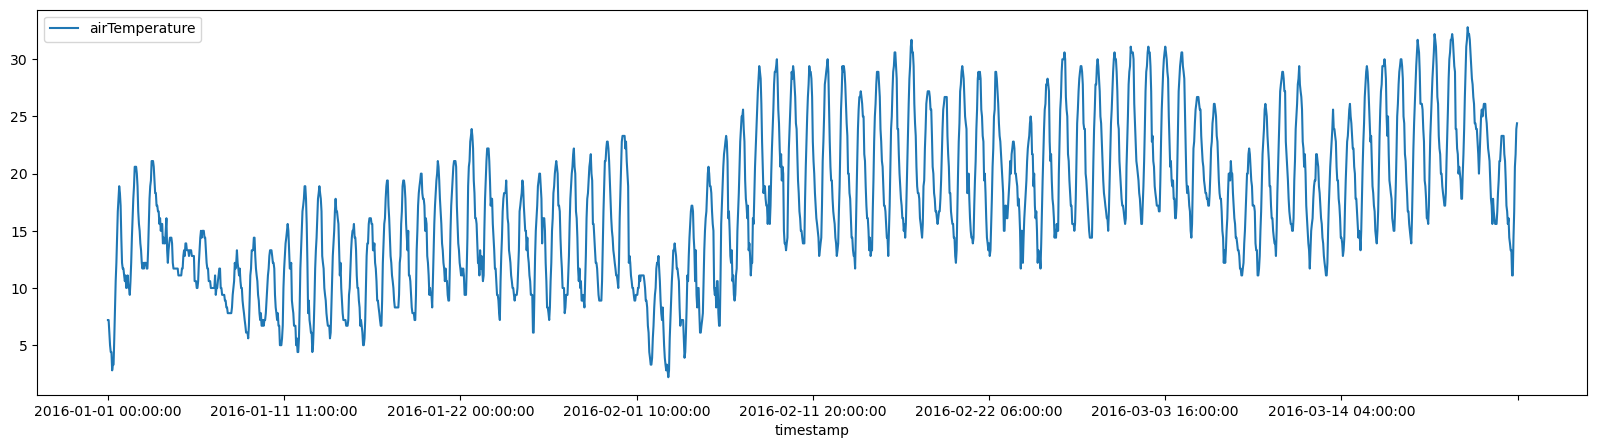

In [10]:
df_tmp.iloc[:2000].plot(x="timestamp", y="airTemperature", figsize=(20, 5))

In [11]:
timestamp_column = "timestamp"
id_columns = []
target_columns = ["airTemperature"]
observable_columns = ["precipDepth1HR",
                      "seaLvlPressure", "windSpeed", "dewTemperature"]

split_config = {
    "train": [0, 12 * 30 * 24],
    "valid": [12 * 30 * 24, 12 * 30 * 24 + 2 * 30 * 24],
    "test": [
        12 * 30 * 24 + 2 * 30 * 24,
        12 * 30 * 24 + 4 * 30 * 24,
    ],
}
# Understanding the split config -- slides

# data = pd.read_csv(
#     dataset_path,
#     parse_dates=[timestamp_column],
# )

data = df_tmp
data[timestamp_column] = pd.to_datetime(data[timestamp_column])

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    # "observable_columns": observable_columns,
    "control_columns": [],
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp, data, split_config, fewshot_fraction=fewshot_fraction, fewshot_location="first"
)
print(f"Data lengths: train = {len(train_dataset)}, val = {
      len(valid_dataset)}, test = {len(test_dataset)}")

Data lengths: train = 1937, val = 1345, test = 1345


/var/folders/zj/mdsgjw6j6l1g69s02_k6y2g40000gp/T/ipykernel_17219/2459243594.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[timestamp_column] = pd.to_datetime(data[timestamp_column])


In [12]:
train_dataset[3]

{'past_values': tensor([[-2.1942],
         [-2.2600],
         [-2.2600],
         [-2.4354],
         [-2.3806],
         [-2.3806],
         [-2.1284],
         [-1.8323],
         [-1.5801],
         [-1.4046],
         [-1.1634],
         [-0.9112],
         [-0.7905],
         [-0.6699],
         [-0.7357],
         [-0.8563],
         [-1.1634],
         [-1.4046],
         [-1.4595],
         [-1.4595],
         [-1.5253],
         [-1.5801],
         [-1.5253],
         [-1.6459],
         [-1.5801],
         [-1.5253],
         [-1.6459],
         [-1.6459],
         [-1.7117],
         [-1.5801],
         [-1.4046],
         [-1.1634],
         [-0.9770],
         [-0.7905],
         [-0.6699],
         [-0.4835],
         [-0.4835],
         [-0.4835],
         [-0.5493],
         [-0.6699],
         [-0.9112],
         [-1.0318],
         [-1.0976],
         [-1.2182],
         [-1.2840],
         [-1.4046],
         [-1.4595],
         [-1.4046],
         [-1.4595],
     

## Zero-shot evaluation method

In [13]:
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-v1", revision=TTM_MODEL_REVISION
)
zeroshot_model

TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=64, out_features=192, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.2, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.2, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
              

In [14]:
temp_dir = tempfile.mkdtemp()
# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
    ),
)

In [15]:
zeroshot_trainer.evaluate(test_dataset)

  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 0.15814977884292603,
 'eval_model_preparation_time': 0.0009,
 'eval_runtime': 1.0074,
 'eval_samples_per_second': 1335.095,
 'eval_steps_per_second': 21.838}

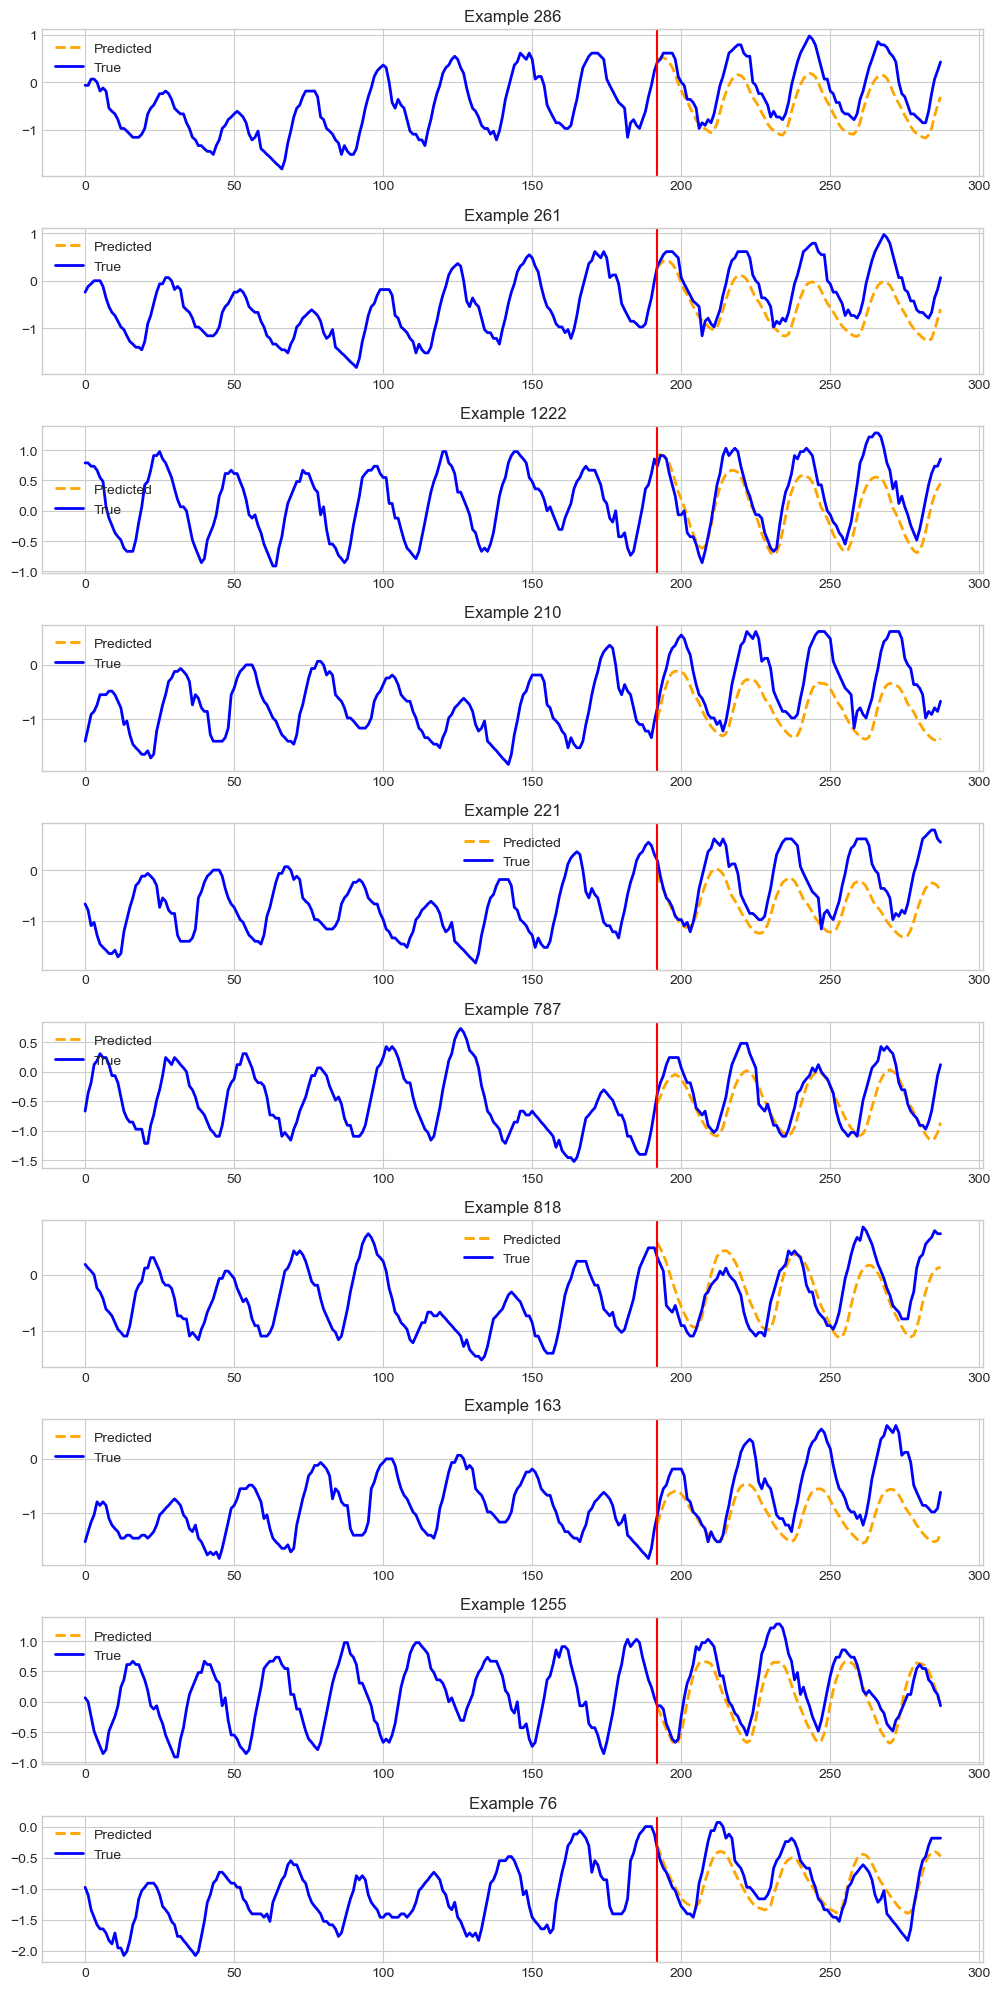

In [16]:
np.random.seed(SEED)

# plot
plot_predictions(
    model=zeroshot_trainer.model,
    dset=test_dataset,
    plot_dir=os.path.join(OUT_DIR, target_dataset),
    plot_prefix="test_zeroshot",
    channel=0,
)

 ## Few-shot finetune and evaluation method

### Load model
Optionally, we can change some parameters of the model, e.g., dropout of the head.

In [17]:
finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-v1", revision=TTM_MODEL_REVISION, head_dropout=0.7
)
finetune_forecast_model

TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=64, out_features=192, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.2, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.2, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
              

### Frezze the TTM backbone

In [18]:
print(
    "Number of params before freezing backbone",
    count_parameters(finetune_forecast_model),
)

# Freeze the backbone of the model
for param in finetune_forecast_model.backbone.parameters():
    param.requires_grad = False

# Count params
print(
    "Number of params after freezing the backbone",
    count_parameters(finetune_forecast_model),
)

Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696


### Finetune few-shot 5%

In [21]:
# Important parameters
learning_rate = 0.0001
# Ideally, we need more epochs (try offline preferably in a gpu for faster computation)
num_epochs = 50
batch_size = 256

In [22]:
print(f"Using learning rate = {learning_rate}")
finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    report_to=None,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    # Make sure to specify a logging directory
    logging_dir=os.path.join(OUT_DIR, "logs"),
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    # Number of epochs with no improvement after which to stop
    early_stopping_patience=10,
    # Minimum improvement required to consider as improvement
    early_stopping_threshold=0.0,
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

# Fine tune
finetune_forecast_trainer.train()

Using learning rate = 0.0001


  0%|          | 0/400 [00:00<?, ?it/s]

INFO:p-18105:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18105:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-18105:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-18108:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18108:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-18108:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-18115:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18115:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-18115:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-18117:t-8667041600:utils.py:_init_num_threads:Note:

{'loss': 0.6532, 'grad_norm': 7.896342754364014, 'learning_rate': 5.066552211758046e-06, 'epoch': 1.0}


INFO:p-18167:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18167:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-18167:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-18170:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18170:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-18170:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-18171:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18171:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-18171:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-18174:t-8667041600:utils.py:_init_num_threads:Note:

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.11486946046352386, 'eval_runtime': 42.4607, 'eval_samples_per_second': 31.676, 'eval_steps_per_second': 0.141, 'epoch': 1.0}


INFO:p-18206:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18206:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-18206:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-18207:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18207:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-18207:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-18209:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18209:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-18209:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-18210:t-8667041600:utils.py:_init_num_threads:Note:

{'loss': 0.6175, 'grad_norm': 14.829468727111816, 'learning_rate': 8.218811612848592e-06, 'epoch': 2.0}


INFO:p-18337:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18337:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-18337:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-18338:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18338:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-18338:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-18340:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18340:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-18340:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-18341:t-8667041600:utils.py:_init_num_threads:Note:

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.11490330100059509, 'eval_runtime': 41.5293, 'eval_samples_per_second': 32.387, 'eval_steps_per_second': 0.144, 'epoch': 2.0}


INFO:p-18364:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18364:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-18364:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-18365:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18365:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-18365:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-18368:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18368:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-18368:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-18369:t-8667041600:utils.py:_init_num_threads:Note:

{'loss': 0.6153, 'grad_norm': 8.037151336669922, 'learning_rate': 1.3316692818427119e-05, 'epoch': 3.0}


INFO:p-18428:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18428:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-18428:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-18429:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18429:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-18429:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-18436:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18436:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-18436:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-18437:t-8667041600:utils.py:_init_num_threads:Note:

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.11497297883033752, 'eval_runtime': 42.0254, 'eval_samples_per_second': 32.004, 'eval_steps_per_second': 0.143, 'epoch': 3.0}


INFO:p-18477:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18477:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-18477:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-18480:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18480:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-18480:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-18490:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18490:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-18490:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-18491:t-8667041600:utils.py:_init_num_threads:Note:

{'loss': 0.6245, 'grad_norm': 10.723520278930664, 'learning_rate': 2.0133647642031602e-05, 'epoch': 4.0}


INFO:p-18570:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18570:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-18570:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-18571:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18571:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-18571:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-18589:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18589:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-18589:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-18590:t-8667041600:utils.py:_init_num_threads:Note:

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.11506114155054092, 'eval_runtime': 42.2114, 'eval_samples_per_second': 31.863, 'eval_steps_per_second': 0.142, 'epoch': 4.0}


INFO:p-18670:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18670:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-18670:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-18672:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18672:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-18672:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-18690:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18690:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-18690:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-18691:t-8667041600:utils.py:_init_num_threads:Note:

{'loss': 0.5439, 'grad_norm': 17.012535095214844, 'learning_rate': 2.836673282347159e-05, 'epoch': 5.0}


INFO:p-18823:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18823:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-18823:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-18824:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18824:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-18824:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-18844:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18844:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-18844:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-18847:t-8667041600:utils.py:_init_num_threads:Note:

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.11518242955207825, 'eval_runtime': 42.2873, 'eval_samples_per_second': 31.806, 'eval_steps_per_second': 0.142, 'epoch': 5.0}


INFO:p-18953:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18953:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-18953:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-18954:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18954:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-18954:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-18959:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18959:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-18959:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-18960:t-8667041600:utils.py:_init_num_threads:Note:

{'loss': 0.5576, 'grad_norm': 8.3453950881958, 'learning_rate': 3.765007272900303e-05, 'epoch': 6.0}


INFO:p-19156:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19156:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-19156:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-19157:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19157:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-19157:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-19158:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19158:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-19158:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-19165:t-8667041600:utils.py:_init_num_threads:Note:

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.11538301408290863, 'eval_runtime': 42.055, 'eval_samples_per_second': 31.982, 'eval_steps_per_second': 0.143, 'epoch': 6.0}


INFO:p-19316:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19316:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-19316:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-19324:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19324:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-19324:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-19330:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19330:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-19330:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-19336:t-8667041600:utils.py:_init_num_threads:Note:

{'loss': 0.5508, 'grad_norm': 7.87746524810791, 'learning_rate': 4.7571118745761504e-05, 'epoch': 7.0}


INFO:p-19385:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19385:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-19385:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-19392:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19392:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-19392:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-19395:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19395:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-19395:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-19396:t-8667041600:utils.py:_init_num_threads:Note:

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.11571525782346725, 'eval_runtime': 41.682, 'eval_samples_per_second': 32.268, 'eval_steps_per_second': 0.144, 'epoch': 7.0}


INFO:p-19442:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19442:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-19442:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-19448:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19448:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-19448:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-19455:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19455:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-19455:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-19456:t-8667041600:utils.py:_init_num_threads:Note:

{'loss': 0.5329, 'grad_norm': 11.720026016235352, 'learning_rate': 5.768898280824173e-05, 'epoch': 8.0}


INFO:p-19514:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19514:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-19514:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-19515:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19515:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-19515:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-19522:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19522:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-19522:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-19524:t-8667041600:utils.py:_init_num_threads:Note:

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.11612732708454132, 'eval_runtime': 42.0422, 'eval_samples_per_second': 31.992, 'eval_steps_per_second': 0.143, 'epoch': 8.0}


INFO:p-19581:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19581:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-19581:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-19583:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19583:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-19583:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-19591:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19591:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-19591:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-19592:t-8667041600:utils.py:_init_num_threads:Note:

{'loss': 0.5273, 'grad_norm': 8.741765022277832, 'learning_rate': 6.755403032085596e-05, 'epoch': 9.0}


INFO:p-19633:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19633:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-19633:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-19647:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19647:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-19647:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-19651:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19651:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-19651:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-19652:t-8667041600:utils.py:_init_num_threads:Note:

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.11660385131835938, 'eval_runtime': 41.8652, 'eval_samples_per_second': 32.127, 'eval_steps_per_second': 0.143, 'epoch': 9.0}


INFO:p-19682:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19682:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-19682:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-19691:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19691:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-19691:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-19692:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19692:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-19692:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-19693:t-8667041600:utils.py:_init_num_threads:Note:

{'loss': 0.4831, 'grad_norm': 8.305253028869629, 'learning_rate': 7.672786177345102e-05, 'epoch': 10.0}


INFO:p-19733:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19733:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-19733:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-19741:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19741:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-19741:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-19742:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19742:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-19742:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-19743:t-8667041600:utils.py:_init_num_threads:Note:

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.11691490560770035, 'eval_runtime': 42.0041, 'eval_samples_per_second': 32.021, 'eval_steps_per_second': 0.143, 'epoch': 10.0}


INFO:p-19820:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19820:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-19820:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-19823:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19823:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-19823:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-19830:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19830:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-19830:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-19831:t-8667041600:utils.py:_init_num_threads:Note:

{'loss': 0.4679, 'grad_norm': 9.635136604309082, 'learning_rate': 8.480279507327434e-05, 'epoch': 11.0}


INFO:p-19890:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19890:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-19890:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-19897:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19897:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-19897:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-19909:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19909:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-19909:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-19915:t-8667041600:utils.py:_init_num_threads:Note:

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.11749427765607834, 'eval_runtime': 42.0963, 'eval_samples_per_second': 31.951, 'eval_steps_per_second': 0.143, 'epoch': 11.0}
{'train_runtime': 1043.8836, 'train_samples_per_second': 92.779, 'train_steps_per_second': 0.383, 'train_loss': 0.5612775493751873, 'epoch': 11.0}
[TrackingCallback] Mean Epoch Time = 52.804087378761984 seconds, Total Train Time = 1043.8590230941772


TrainOutput(global_step=88, training_loss=0.5612775493751873, metrics={'train_runtime': 1043.8836, 'train_samples_per_second': 92.779, 'train_steps_per_second': 0.383, 'total_flos': 52709686149120.0, 'train_loss': 0.5612775493751873, 'epoch': 11.0})

In [179]:
finetune_forecast_trainer.evaluate(test_dataset)

INFO:p-13271:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-13271:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-13271:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-13272:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-13272:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-13272:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-13273:t-8667041600:utils.py:_init_num_threads:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-13273:t-8667041600:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
INFO:p-13273:t-8667041600:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-13280:t-8667041600:utils.py:_init_num_threads:Note:

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.1634601652622223,
 'eval_runtime': 42.0018,
 'eval_samples_per_second': 32.022,
 'eval_steps_per_second': 0.143,
 'epoch': 10.0}

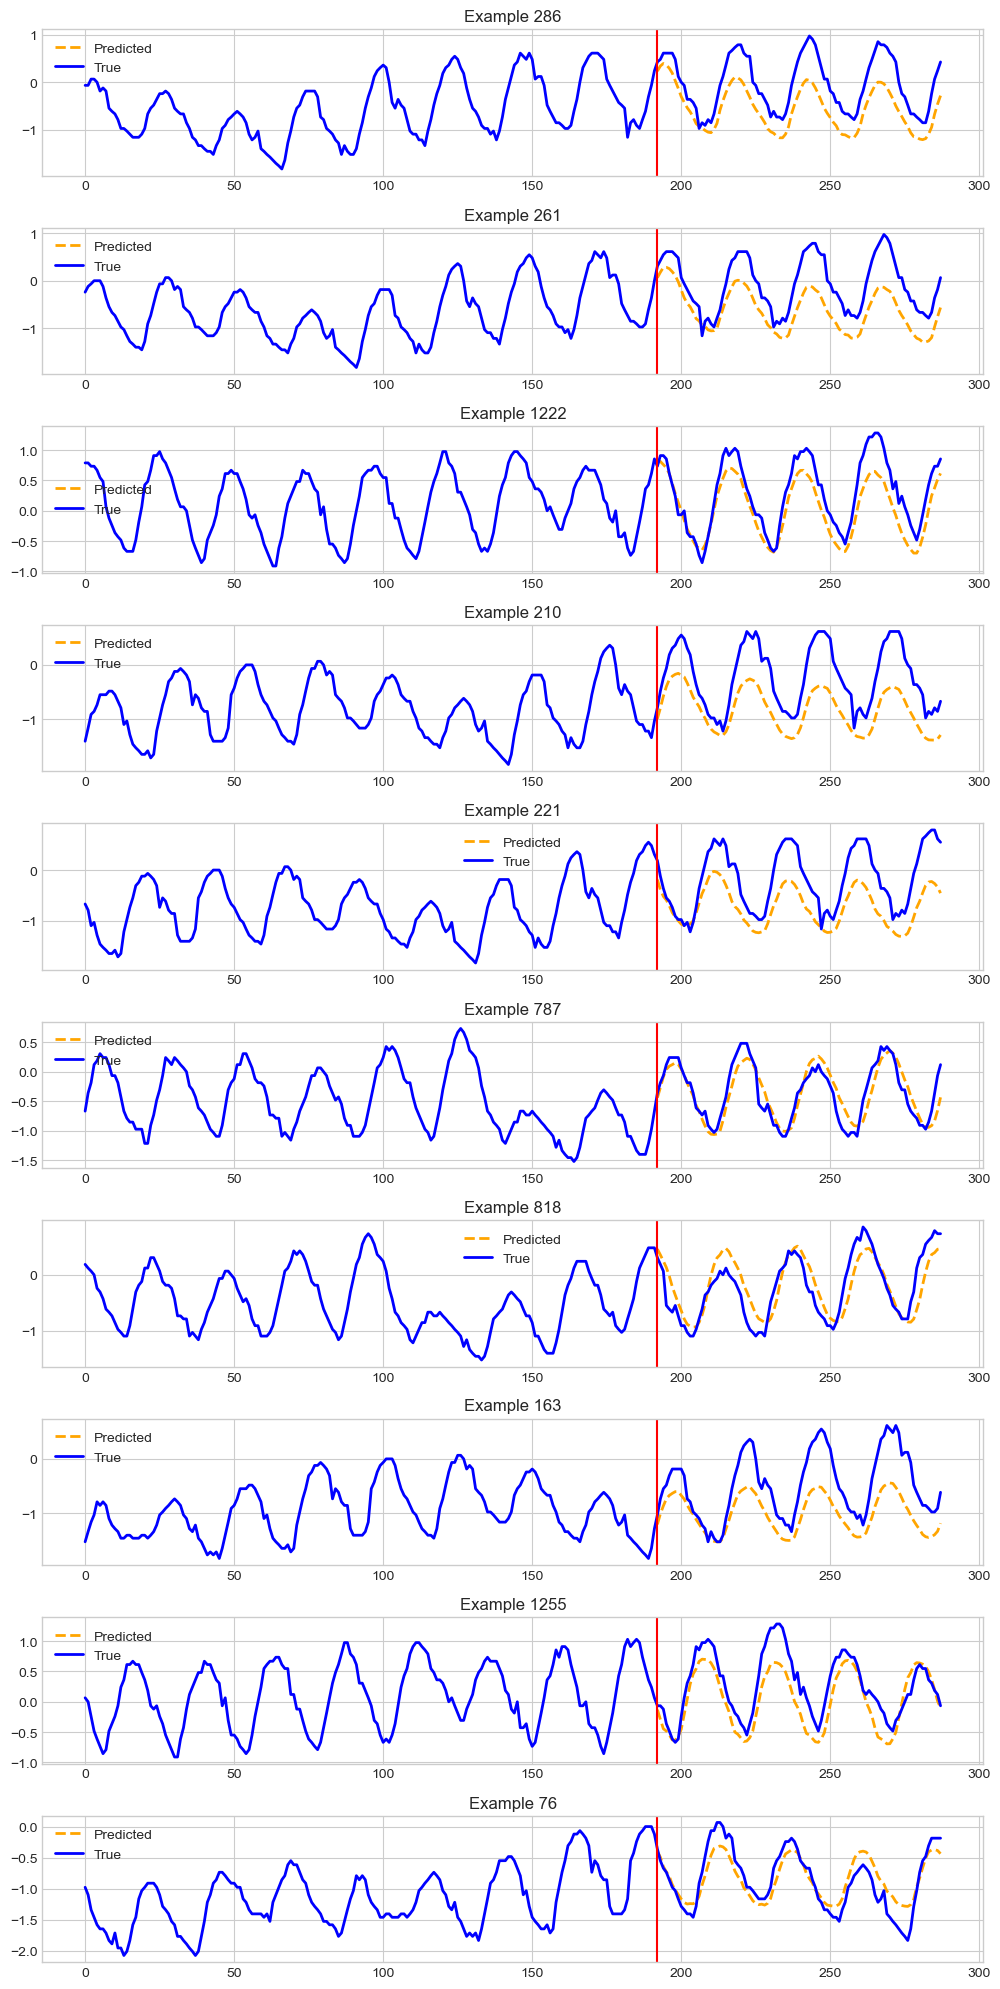

In [180]:
plot_predictions(
    model=finetune_forecast_trainer.model,
    dset=test_dataset,
    plot_dir=os.path.join(OUT_DIR, target_dataset),
    plot_prefix=f"test_fewshot_ep_{num_epochs}",
    channel=0,
)

## Hands-on Questions with answers

### Q 15.	Zero-shot on etth1. 
In your notebook, modify the zero-shot code to try it on etth1 dataset. Etth1 is available on https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv. What is the evaluation error you get on etth1?
Use the following train/val/test splits:
```
split_config = {
                "train": [0, 12 * 30 * 24],
                "valid": [12 * 30 * 24, 12 * 30 * 24 + 4 * 30 * 24],
                "test": [
                    12 * 30 * 24 + 4 * 30 * 24,
                    12 * 30 * 24 + 8 * 30 * 24,
                ],
            }
```

In [17]:
DATA_ROOT_PATH = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"

In [18]:
dataset_path = DATA_ROOT_PATH
timestamp_column = "date"
id_columns = []
target_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]
split_config = {
    "train": [0, 12 * 30 * 24],
    "valid": [12 * 30 * 24, 12 * 30 * 24 + 4 * 30 * 24],
    "test": [
        12 * 30 * 24 + 4 * 30 * 24,
        12 * 30 * 24 + 8 * 30 * 24,
    ],
}
# Understanding the split config -- slides

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp, data, split_config, fewshot_fraction=fewshot_fraction, fewshot_location="first"
)
print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")

Data lengths: train = 311, val = 2785, test = 2785


In [19]:
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-v1", revision=TTM_MODEL_REVISION
)
temp_dir = tempfile.mkdtemp()
# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
    ),
)
zeroshot_trainer.evaluate(test_dataset)

  0%|          | 0/44 [00:00<?, ?it/s]

{'eval_loss': 0.36317431926727295,
 'eval_runtime': 1.1905,
 'eval_samples_per_second': 2339.346,
 'eval_steps_per_second': 36.959}

### Q 16.	Zero-shot on etth1 by truncating the length
Let’s say your application needs to forecast 24 hours in the future. You can still use the 512-96 TTM model and set the `prediction_filter_length` argument during model loading. Try it on etth1, and note the evaluation error (on all channels)?

In [20]:
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-v1", revision=TTM_MODEL_REVISION, prediction_filter_length=24
)
temp_dir = tempfile.mkdtemp()
# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
    ),
)
zeroshot_trainer.evaluate(test_dataset)

  0%|          | 0/44 [00:00<?, ?it/s]

{'eval_loss': 0.31531819701194763,
 'eval_runtime': 1.3327,
 'eval_samples_per_second': 2089.706,
 'eval_steps_per_second': 33.015}

### Q 17.	Few-shot on etth1
Try few-shot 5% forecasting on etth1. Freeze the backbone and fine-tune for only 1 epoch. What is the evaluation error you get?

In [21]:
finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-v1", revision=TTM_MODEL_REVISION, head_dropout=0.7
)
finetune_forecast_model

TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=64, out_features=192, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.2, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.2, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
              

In [22]:
print(
    "Number of params before freezing backbone",
    count_parameters(finetune_forecast_model),
)

# Freeze the backbone of the model
for param in finetune_forecast_model.backbone.parameters():
    param.requires_grad = False

# Count params
print(
    "Number of params after freezing the backbone",
    count_parameters(finetune_forecast_model),
)

Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696


In [23]:
print(f"Using learning rate = {learning_rate}")
finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    report_to=None,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

# Fine tune
finetune_forecast_trainer.train()

Using learning rate = 0.001


/Users/wmgifford/miniconda3/envs/tsfm_public/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

{'loss': 1.1631, 'grad_norm': 12.011261940002441, 'learning_rate': 0.00018825834605023693, 'epoch': 1.0}


  0%|          | 0/44 [00:00<?, ?it/s]

{'eval_loss': 0.6572275161743164, 'eval_runtime': 56.1245, 'eval_samples_per_second': 49.622, 'eval_steps_per_second': 0.784, 'epoch': 1.0}
{'train_runtime': 97.9334, 'train_samples_per_second': 3.176, 'train_steps_per_second': 0.051, 'train_loss': 1.1631193161010742, 'epoch': 1.0}
[TrackingCallback] Mean Epoch Time = 41.72416400909424 seconds, Total Train Time = 97.9364070892334


TrainOutput(global_step=5, training_loss=1.1631193161010742, metrics={'train_runtime': 97.9334, 'train_samples_per_second': 3.176, 'train_steps_per_second': 0.051, 'total_flos': 5385506488320.0, 'train_loss': 1.1631193161010742, 'epoch': 1.0})

In [24]:
finetune_forecast_trainer.evaluate(test_dataset)

  0%|          | 0/44 [00:00<?, ?it/s]

{'eval_loss': 0.36338433623313904,
 'eval_runtime': 57.7465,
 'eval_samples_per_second': 48.228,
 'eval_steps_per_second': 0.762,
 'epoch': 1.0}

### Q 18.	Few-shot on etth1 by changing loss function
Try few-shot 5% forecasting on etth1 by changing the `loss` to `mae` (mean absolute error). Freeze the backbone and fine-tune for only 1 epoch. What is the evaluation error you get?

In [25]:
finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-v1", revision=TTM_MODEL_REVISION, head_dropout=0.7, loss="mae"
)

In [26]:
print(
    "Number of params before freezing backbone",
    count_parameters(finetune_forecast_model),
)

# Freeze the backbone of the model
for param in finetune_forecast_model.backbone.parameters():
    param.requires_grad = False

# Count params
print(
    "Number of params after freezing the backbone",
    count_parameters(finetune_forecast_model),
)

Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696


In [27]:
print(f"Using learning rate = {learning_rate}")
finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    report_to=None,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

# Fine tune
finetune_forecast_trainer.train()

Using learning rate = 0.001


  0%|          | 0/5 [00:00<?, ?it/s]

{'loss': 0.7409, 'grad_norm': 2.889449119567871, 'learning_rate': 0.00018825834605023693, 'epoch': 1.0}


  0%|          | 0/44 [00:00<?, ?it/s]

{'eval_loss': 0.5517779588699341, 'eval_runtime': 57.1901, 'eval_samples_per_second': 48.697, 'eval_steps_per_second': 0.769, 'epoch': 1.0}
{'train_runtime': 99.2382, 'train_samples_per_second': 3.134, 'train_steps_per_second': 0.05, 'train_loss': 0.7408991813659668, 'epoch': 1.0}
[TrackingCallback] Mean Epoch Time = 41.965312004089355 seconds, Total Train Time = 99.23600888252258


TrainOutput(global_step=5, training_loss=0.7408991813659668, metrics={'train_runtime': 99.2382, 'train_samples_per_second': 3.134, 'train_steps_per_second': 0.05, 'total_flos': 5385506488320.0, 'train_loss': 0.7408991813659668, 'epoch': 1.0})

In [28]:
finetune_forecast_trainer.evaluate(test_dataset)

  0%|          | 0/44 [00:00<?, ?it/s]

{'eval_loss': 0.3972043991088867,
 'eval_runtime': 56.7928,
 'eval_samples_per_second': 49.038,
 'eval_steps_per_second': 0.775,
 'epoch': 1.0}

### Q 19.	Zero-shot on channel 0 and 2 for etth1
In your notebook, add `prediction_channel_indices=[0,2]` during model loading to forecast only 0th and 2nd channels. In this case, execute the following code and note the output shape.
```
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained("ibm-granite/granite-timeseries-ttm-v1", revision=TTM_MODEL_REVISION, prediction_channel_indices=[0,2])
output = zeroshot_model.forward(test_dataset[0]['past_values'].unsqueeze(0), return_loss=False)
output.prediction_outputs.shape
```

In [29]:
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-v1", revision=TTM_MODEL_REVISION, prediction_channel_indices=[0, 2]
)
output = zeroshot_model.forward(test_dataset[0]["past_values"].unsqueeze(0), return_loss=False)
output.prediction_outputs.shape

torch.Size([1, 96, 2])